In [7]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray as xr
import netCDF4 as nc4
import random

import itertools

### For this project, I implemented incremental adjustments to a synthetically generated cloud mask used in the PREFIRE mission, enhancing the realism of cloud spatial patterns.

In [2]:
FillValue = -9999.0

def cloud_mask_calc(CF_profile,
                    CM_profile_previous,
                    QI_profile,
                    QL_profile,
                    pres_profile,
                    surface_pres,
                    alpha):
    """
    Written by Kyle Mattingly
    Cloud correlation updates by Cameron Bertossa
    
    Determine cloud mask for each vertical layer of a single profile using a 
    max-overlap like assumption applied to cloud fraction profile:
    
    Find CFMax in profile. Draw random number for CFmax at the layer of CFmax.
    - If clear, then the entire profile is clear.
    - If cloudy, set layer of CFmax to cloudy, and then do random draws in the
      rest of the profile according to (CFprofile / CFmax).
      
    Since PCRTM only allows 36 cloud layers: after creating the intial cloud
    mask profile, check if the number of cloud levels is less than 37. If true,
    do nothing; if >= 37, change cloud layers to clear to get down to 36, by
    "removing" the cloud layers with the smallest (qi + ql) values.
    
    Since PCRTM can't handle below-surface cloud layers: find the layers in each
    profile where the pressure is greater than the surface pressure. Then zero out
    cloud mask, cloud fraction, QI, and QL on all these layers *except* the first
    below-surface layer.
    
    Parameters
    ----------
    CF_profile : numpy.ndarray
        Cloud fraction profile for a single TIRS scene.
        Dimensions: (zlevels)
    CM_profile_previous : numpy.ndarray
        Cloud mask profile for a single TIRS scene which precedes the current
        scene in the atrack direction.
        Dimensions: (zlevels)
    QI_profile : numpy.ndarray
        QI profile for a single TIRS scene.
        Dimensions: (zlevels)
    QL_profile : numpy.ndarray
        QL profile for a single TIRS scene.
        Dimensions: (zlevels)
    pres_profile : numpy.ndarray
        Pressure profile for a single TIRS scene.
        Dimensions: (zlevels)
    surface_pres : float
        Surface pressure for a single TIRS scene.
    alpha : float
        cloud decoupling parameter (bigger = less influence from previous footprint);
        in the limit of alpha -> infty cloud fields are randomly sampled

    Returns
    -------
    cloud_mask_profile : numpy.ndarray
        Cloud mask profile with below-surface layers zeroed out.
        Dimensions: (zlevels)
    CF_profile : numpy.ndarray
        Cloud fraction profile with below-surface layers zeroed out.
        Dimensions: (zlevels)
    QI_profile : numpy.ndarray
        QI profile with below-surface layers zeroed out.
        Dimensions: (zlevels)
    QL_profile : numpy.ndarray
        QL profile with below-surface layers zeroed out.
        Dimensions: (zlevels)

    """
    
    # Adapted from /home/merrelli/projects/PREFIRE_misc/GEOS_cloudfraction.py

    #adjust CF to account for previous scene's mask result, then clip to be [0,1]
    CF_profile = np.clip(CF_profile - ((-1)**CM_profile_previous)/alpha, a_min=0, a_max=1)

    CF_max_layer = CF_profile.argmax()
    CF_profile_max = CF_profile[CF_max_layer]
    # Compute a scaled profile where the max CF is 100%.
    CF_profile_scaled = CF_profile / CF_profile_max
    
    nlayers = CF_profile.shape[0]
    cloud_mask_profile_full = np.zeros(CF_profile.shape, dtype='int8')
    # for max overlap: draw scalar random number to decide if the profile
    # is cloudy or not....
    if np.random.uniform(0,1,1) < CF_profile_max:
        # ... if cloudy, then decide which layers have cloud by drawing
        # random numbers against the scaled profile. Since this has a peak of 100%,
        # we should automatically get at least one cloud layer at the layer that
        # has the peak CF.
        cloud_mask_profile_full[:] = np.random.uniform(0,1,(nlayers,)) < CF_profile_scaled
    # (if clear, entire cloud mask profile remains 0.)
    
    # If number of cloud levels is < 37, keep cloud mask profile as is
    if np.sum(cloud_mask_profile_full) < 37:
        cloud_mask_profile = cloud_mask_profile_full
        
    # If number of cloud levels is >= 37, remove cloud layers with the smallest
    # (qi + ql) values, to get down to 36 cloud levels.
    else:
        # In determining the 36 largest qcloud (qi + ql) values, consider *only* 
        # the values where cloud mask = 1.
        qi_mask = np.where(cloud_mask_profile_full == 1, QI_profile, 0)
        ql_mask = np.where(cloud_mask_profile_full == 1, QL_profile, 0)
        qcloud_thresh = np.sort(qi_mask + ql_mask)[::-1][35]
        cloud_mask_profile = np.where((qi_mask + ql_mask) >= qcloud_thresh, 1, 0)
        
        # Break "ties" where more than one level has qi_mask + ql_mask == qcloud_thresh
        # - Set cloud_mask equal to 0 in these cases
        if np.sum(cloud_mask_profile) > 36:
            cloud_mask_profile[(qi_mask + ql_mask) == qcloud_thresh] = 0
    
    # Keep data from the first level with pressure > surface pressure, because it 
    # contains unique data (different from first above-surface level), and shouldn't 
    # cause PCRTM to break.
    below_sfc_ixs = np.where(pres_profile > surface_pres)[0][1:]
    cloud_mask_profile[below_sfc_ixs] = 0
    CF_profile[below_sfc_ixs] = 0
    QI_profile[below_sfc_ixs] = 0
    QL_profile[below_sfc_ixs] = 0
            
    return cloud_mask_profile, CF_profile, QI_profile, QL_profile


def apply_cloud_mask(CF_profiles_allscenes,
                     QI_profiles_allscenes,
                     QL_profiles_allscenes,
                     pres_profiles_allscenes,
                     surface_pres_allscenes,
                     random_seed=139, alpha=3):
    """
    Written by Kyle Mattingly
    
    Apply cloud mask calculation to cloud fraction profiles for all TIRS scenes
    in a given orbit file.
    
    Parameters
    ----------
    CF_profs_allscenes : numpy.ndarray
        Cloud fraction profiles for all TIRS scenes in a given orbit file.
        Dimensions: (atrack, xtrack, zlevels)
    QI_profs_allscenes : numpy.ndarray
        QI profiles for all TIRS scenes in a given orbit file.
        Dimensions: (atrack, xtrack, zlevels)
    QL_profs_allscenes : numpy.ndarray
        QL profiles for all TIRS scenes in a given orbit file.
        Dimensions: (atrack, xtrack, zlevels)
    pres_profiles_allscenes : numpy.ndarray
        Pressure profiles for all TIRS scenes in a given orbit file (*after* 
        interpolation to PCRTM levels).
        Dimensions: (atrack, xtrack, zlevels)
    surface_pres_allscenes : numpy.ndarray
        Surface pressure for all TIRS scenes in a given orbit file.
        (For Anc-SimTruth data without surface correction implemented, this is
        actually the lowest pressure level in the uncorrected pressure profile,
        *not* the surface pressure from the met analysis.)
        Dimensions: (atrack, xtrack)
    random_seed : int
        Sets the random seed to generate the same set of random numbers with
        every run.

    Returns
    -------
    cloud_mask_3d : numpy.ndarray
        Cloud mask profiles for all TIRS scenes in a given orbit file.
        Dimensions: (atrack, xtrack, zlevels)
    CF_adj_3d : numpy.ndarray
        Cloud fraction adjusted with zeroed out below-surface layers.
        Dimensions: (atrack, xtrack, zlevels)
    QI_adj_3d : numpy.ndarray
        QI adjusted with zeroed out below-surface layers.
        Dimensions: (atrack, xtrack, zlevels)
    QL_adj_3d : numpy.ndarray
        QL adjusted with zeroed out below-surface layers.
        Dimensions: (atrack, xtrack, zlevels)

    """
    np.random.seed(random_seed)
    
    orbit_shape_3d = CF_profiles_allscenes.shape
    cloud_mask_3d = np.zeros(orbit_shape_3d, dtype='int8')
    CF_adj_3d = np.zeros(orbit_shape_3d, dtype=CF_profiles_allscenes.dtype)
    QI_adj_3d = np.zeros(orbit_shape_3d, dtype=QI_profiles_allscenes.dtype)
    QL_adj_3d = np.zeros(orbit_shape_3d, dtype=QL_profiles_allscenes.dtype)
    
    for atrack_ix, xtrack_ix in np.ndindex(orbit_shape_3d[:-1]):
        cloud_mask_3d[atrack_ix, xtrack_ix],\
        CF_adj_3d[atrack_ix, xtrack_ix],\
        QI_adj_3d[atrack_ix, xtrack_ix],\
        QL_adj_3d[atrack_ix, xtrack_ix] = cloud_mask_calc(CF_profiles_allscenes[atrack_ix, xtrack_ix],
                                                          cloud_mask_3d[atrack_ix-1, xtrack_ix],
                                                          QI_profiles_allscenes[atrack_ix, xtrack_ix],
                                                          QL_profiles_allscenes[atrack_ix, xtrack_ix],
                                                          pres_profiles_allscenes[atrack_ix, xtrack_ix],
                                                          surface_pres_allscenes[atrack_ix, xtrack_ix], alpha=alpha)
    
    return cloud_mask_3d, CF_adj_3d, QI_adj_3d, QL_adj_3d


In [3]:
def orbit_extract(AncSimfile):
    """
    Simple function to extract GEOS cloudfrac/cloudmask interpolated onto TIRS footprints from an orbit sim file
    lats (atrack, xtrack)
    lons (atrack, xtrack)
    cmaskz (atrack,xtrack,zlev)
    cfracz (atrack,xtrack,zlev)
    """
    ds_anc= xr.open_dataset(AncSimfile, group ='Anc-SimTruth')
    lats = np.array(xr.open_dataset(AncSimfile, group ='Geometry').latitude)
    lons = np.array(xr.open_dataset(AncSimfile, group ='Geometry').longitude)
    cmaskz = np.array(ds_anc['cloud_mask'])
    cfracz = np.array(ds_anc['cloud_fraction'])
    qi = np.array(ds_anc['qi'])
    ql = np.array(ds_anc['ql'])
    ps  = np.array(ds_anc['surface_pressure'])
    pz = np.array(ds_anc['pressure_profile'])
    
    return lons,lats,cmaskz,cfracz,qi,ql,ps,pz


def calc_cloud_lengths(binary_data):
    """
    Function to calculate continuous stretches of '1s' (representing clouds) broken up by '0s' (clear) 
    used to calc. cloud length scales
    """
    keys = np.array([k for k, g in itertools.groupby(binary_data)])
    lengths = np.array([sum(1 for _ in group) for _k, group in itertools.groupby(binary_data)]) #finding continuous streteches of 1s
    cloud_lengths = lengths[keys==1]*5 #compile all our lengths, we multiply by 5 to go from indices to km
    # TODO, check this-- converting to km
    #we'll call it ~5km per footprint (we have overlap, makes it complicated), probably ok-ish if we're consistent
    return cloud_lengths


def flatten_clouds(binary_2dmask):
    """
    essentially just flatten height-dimension for a top-down POV, if there's a cloud at any level its cloudy
    expects shape (nray, nheight)
    """
    binary_1dmask = np.sum(binary_2dmask,axis=-1)
    binary_1dmask[binary_1dmask>1] = 1
    return binary_1dmask

In [4]:
dd= '001' #day to extract

ancpath='/data/datasim/v01/2021/{}/*Truth*'.format(dd)
ancfiles = np.sort(glob.glob(ancpath))[slice(0,1)] #just look at a single file for now


for ii in range(len(ancfiles)):
    if ii==0:
        lons, lats, cmaskz, cfracz,qi,ql,ps,pz = orbit_extract(ancfiles[ii])
    else:
        lons_ii,lats_ii,cmaskz_ii, cfracz_ii, qi_ii, ql_ii, ps_ii, pz_ii = orbit_extract(ancfiles[ii])
        cmaskz = np.vstack( (cmaskz,cmaskz_ii))
        cfracz = np.vstack( (cfracz,cfracz_ii))
        qi = np.vstack( (qi, qi_ii) )
        ql = np.vstack( (ql, ql_ii) )
        ps = np.vstack( (ps, ps_ii) )
        pz = np.vstack( (pz, pz_ii) )
        lons = np.vstack((lons,lons_ii))
        lats = np.vstack((lats,lats_ii))


/home/cbertossa/miniconda3/envs/tfjup/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide


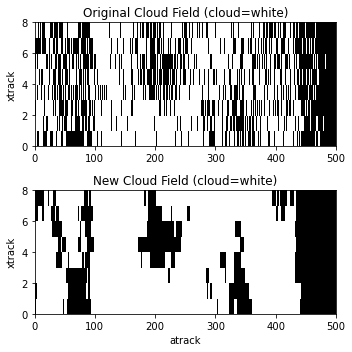

In [5]:
#produce cloud mask for this single orbit. Use original random sampling method
cmask_original, CF_adj_3d, QI_adj_3d, QL_adj_3d= apply_cloud_mask(cfracz,
                     qi, ql,pz,ps, random_seed=139, alpha=100000)

#use newly developed method, which included correlated sampling
cmask_correlated, CF_adj_3d, QI_adj_3d, QL_adj_3d= apply_cloud_mask(cfracz,
                     qi, ql,pz,ps, random_seed=139, alpha=3)

fig,ax=plt.subplots(2,1, figsize=(5,5))


#'flatten' our height dimension for the cloud mask
origmask_flat= np.array([flatten_clouds(cmask_original[:,x]) for x in range(8) ])
corrmask_flat= np.array([flatten_clouds(cmask_correlated[:,x]) for x in range(8) ])

#pick a portion of the orbit to plot
nray_ss = slice(0,500)

#cloud=white, clear=black
ax[0].pcolormesh(origmask_flat[:,nray_ss], cmap = 'binary_r')#plot original clouds
ax[1].pcolormesh(corrmask_flat[:,nray_ss], cmap = 'binary_r')#plot new clouds

ax[0].set_title('Original Cloud Field (cloud=white)')
ax[1].set_title('New Cloud Field (cloud=white)')

ax[0].set_ylabel('xtrack')
ax[1].set_ylabel('xtrack')

ax[1].set_xlabel('atrack')

plt.tight_layout()
plt.show()

In [8]:
#calculate the cloud chord lengths with 'flattened' clouds
#first using the uncorrelated method (original)
orig_lengths = np.concatenate([ calc_cloud_lengths( flatten_clouds(cmask_original[:,x])) for x in range(8) ]).ravel()
#then with the addition of correlated sampling
corr_lengths = np.concatenate([ calc_cloud_lengths( flatten_clouds(cmask_correlated[:,x])) for x in range(8) ]).ravel()

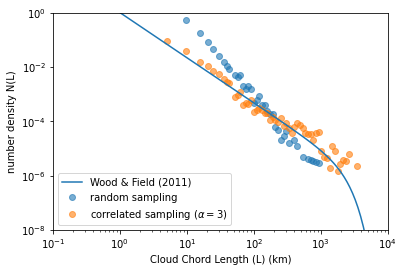

In [9]:
#model produced by Wood and Field (2011) for cloud size densities
#we want to approximately follow this
beta = 1.66
Lstar =  2100 # (km)
L = np.logspace(0,4,100)
N_l = L**(-beta)*np.exp(-(L/Lstar)**2)
plt.plot(L,N_l, label = 'Wood & Field (2011)')

logbins = L
cents = (logbins[:-1] + logbins[1:])/2
# note that there's an additional factor in WF11 to calcualte densities, but this is 
#a constant based on total occurences (vertical shift, no change in slope), just approx this.
#we care mostly just about following the shape of the curve, rather than the actual values
shift = 1/4000

#calculate densities for original random sampling of clouds
N_i,_ = np.histogram(orig_lengths, bins=logbins) #counts of each logbin
ntilde_L = N_i/np.diff(logbins)
plt.scatter(cents,ntilde_L*shift, alpha=0.6,  label = 'random sampling')

#calcualte size densities for new correlated sampling
N_i,_ = np.histogram(corr_lengths, bins=logbins)
ntilde_L = N_i/np.diff(logbins)
plt.scatter(cents, ntilde_L*shift, alpha=0.6, label = r'correlated sampling ($\alpha=$3)')

#adjust axes.
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8, 1e0)
plt.xlim(1e-1,1e4)
plt.xlabel('Cloud Chord Length (L) (km)')
plt.ylabel('number density N(L)')
plt.legend()
plt.savefig('./CCL.png',dpi=300, bbox_inches='tight')
plt.show()

There's some fudge factors but this is much closer in the spot checks and size densities. With the simple max overlap, we get too many small clouds and not enough large clouds; by correlating the sampling we get closer to Wood and Field's empirically derived distribution.